In [15]:
import os
import numpy as np
import pandas as pd
import json
import shutil
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Dropout
import zipfile
from google.colab import files
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping


# Clean the directory
current_dir = './'
for item in os.listdir(current_dir):
    if item not in ['.config', 'sample_data']:
        item_path = os.path.join(current_dir, item)
        if os.path.isfile(item_path):
            os.remove(item_path)
        elif os.path.isdir(item_path):
            shutil.rmtree(item_path)

print("Directory cleared. Current contents:", os.listdir(current_dir))

# Upload files
uploaded = files.upload()

# Extract and organize data
zip_file_path = './theft_protection.zip'
extraction_path = './theft_protection'
base_dir = './trace_data'

if os.path.exists(zip_file_path):
    with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
        print("Contents of theft_protection.zip:")
        print(zip_ref.namelist())
        zip_ref.extractall(extraction_path)
    if not os.path.exists(base_dir):
        os.makedirs(base_dir)
    if os.path.exists('./theft_protection'):
        shutil.move('./theft_protection', f'{base_dir}/theft_protection')
else:
    print("Zip file not found.")

from utils import get_paths, read_traces, read_json, mapint2var, is_consistent
from anomaly_detection import test_single, merge_detections, get_correct_detections

# Configuration
CODE = 'theft_protection'
BEHAVIOUR_FAULTY = 'faulty_data'
BEHAVIOUR_NORMAL = 'normal'
THREAD = 'single'
VER = 3

normalbase_path = f'{base_dir}/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_NORMAL}'
faultybase_path = f'{base_dir}/{CODE}/{THREAD}_thread/version_{VER}/{BEHAVIOUR_FAULTY}'

print("Normal base path:", normalbase_path)
print("Faulty base path:", faultybase_path)

train_base_path = os.path.join(normalbase_path, 'train_data')
train_data_path = [os.path.join(train_base_path, x) for x in os.listdir(train_base_path)]
train_varlist_path = [os.path.join(normalbase_path, x) for x in os.listdir(normalbase_path) if 'varlist' in x]

paths_log, paths_traces, varlist_path, paths_label = get_paths(faultybase_path)

train_data_path = [x for x in train_data_path if '.DS_Store' not in x]
train_varlist_path = [x for x in train_varlist_path if '.DS_Store' not in x]
paths_log = [x for x in paths_log if '.DS_Store' not in x]
paths_traces = [x for x in paths_traces if '.DS_Store' not in x]
varlist_path = [x for x in varlist_path if '.DS_Store' not in x]
paths_label = [x for x in paths_label if '.DS_Store' not in x]

paths_log.sort()
paths_traces.sort()
varlist_path.sort()
paths_label.sort()

test_data_path = paths_traces
test_label_path = paths_label

Directory cleared. Current contents: ['.config', 'sample_data']


Saving anomaly_detection.py to anomaly_detection.py
Saving theft_protection.zip to theft_protection.zip
Saving utils.py to utils.py
Contents of theft_protection.zip:
['single_thread/.DS_Store', 'single_thread/version description.rtf', 'single_thread/version_1.1/', 'single_thread/version_1.1/.DS_Store', 'single_thread/version_1.1/normal/', 'single_thread/version_1.1/normal/log1', 'single_thread/version_1.1/normal/log2', 'single_thread/version_1.1/normal/log3', 'single_thread/version_1.1/normal/log4', 'single_thread/version_1.1/normal/log5', 'single_thread/version_1.1/normal/log6', 'single_thread/version_1.1/normal/trace1', 'single_thread/version_1.1/normal/trace2', 'single_thread/version_1.1/normal/trace3', 'single_thread/version_1.1/normal/trace4', 'single_thread/version_1.1/normal/trace5', 'single_thread/version_1.1/normal/trace6', 'single_thread/version_1.1/semantic_error/', 'single_thread/version_1.1/semantic_error/log1', 'single_thread/version_1.1/semantic_error/log2', 'single_thre

In [16]:
test_data_path

['./trace_data/theft_protection/single_thread/version_3/faulty_data/trace_trial1.json',
 './trace_data/theft_protection/single_thread/version_3/faulty_data/trace_trial2.json',
 './trace_data/theft_protection/single_thread/version_3/faulty_data/trace_trial3.json']

In [17]:
test_label_path

['./trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace_trial1_labels.json',
 './trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace_trial2_labels.json',
 './trace_data/theft_protection/single_thread/version_3/faulty_data/labels/trace_trial3_labels.json']

In [18]:
train_data_path

['./trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_150_900.json',
 './trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_0_110.json',
 './trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_1250_2000.json',
 './trace_data/theft_protection/single_thread/version_3/normal/train_data/interval_2050_2300.json']

In [19]:
# Check consistency
if VER == 3:
    check_con, _ = is_consistent([train_varlist_path[0]] + varlist_path)
    if check_con:
        to_number = read_json(varlist_path[0])
        from_number = mapint2var(to_number)
    else:
        to_number = read_json(train_varlist_path[0])
        from_number = mapint2var(to_number)

sorted_keys = list(from_number.keys())
sorted_keys.sort()
var_list = [from_number[key] for key in sorted_keys]

# Load training data
def load_data(file_paths):
    data = []
    for file in file_paths:
        traces = read_traces(file)
        if isinstance(traces, list):
            data.append(traces)
    return data

train_data = load_data(train_data_path)
scaler = MinMaxScaler() #Min Max scaler
train_data_scaled = []
for td in train_data:
    scaled_data = scaler.fit_transform(td)
    train_data_scaled.append(scaled_data)
#train_data_scaled = scaler.fit_transform(train_data)


varlist 1 is consistent with varlist 0
varlist 2 is consistent with varlist 0
varlist 3 is consistent with varlist 0


In [20]:
len(train_data_scaled)

4

In [21]:
# Prepare LSTM training data
sequence_length = 10       # Already tuned parameter value
X_train, y_train = [], []
for single_data_scaled in train_data_scaled:
    for i in range(len(single_data_scaled) - sequence_length):
        X_train.append(single_data_scaled[i:i + sequence_length])
        y_train.append(single_data_scaled[i + sequence_length])

X_train, y_train = np.array(X_train), np.array(y_train)

# test_size = 0.2 (20% of data used for validation and 80% for training)
# random_state = 42 (to ensure data split remains same every time)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

In [22]:
# Define GRU model
# Layers 128, 64 and 32 are chosen by parameter tuning
model = Sequential([
    GRU(128, activation='relu', return_sequences=True, input_shape=(sequence_length, 2), kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    GRU(64, activation='relu', return_sequences=False, kernel_regularizer=l2(0.01)),
    Dropout(0.4),
    Dense(X_train.shape[2], activation='linear')
])

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

# Train model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=100, batch_size=32, callbacks=[early_stopping], verbose=1)

Epoch 1/100


/usr/local/lib/python3.11/dist-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


46/46 ━━━━━━━━━━━━━━━━━━━━ 7s 58ms/step - loss: 1.3761 - mae: 0.2788 - val_loss: 0.5809 - val_mae: 0.1486
Epoch 2/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.4689 - mae: 0.1679 - val_loss: 0.2025 - val_mae: 0.1352
Epoch 3/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.1760 - mae: 0.1621 - val_loss: 0.0863 - val_mae: 0.1243
Epoch 4/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - loss: 0.0814 - mae: 0.1508 - val_loss: 0.0546 - val_mae: 0.1258
Epoch 5/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0609 - mae: 0.1534 - val_loss: 0.0457 - val_mae: 0.1143
Epoch 6/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0517 - mae: 0.1494 - val_loss: 0.0451 - val_mae: 0.1398
Epoch 7/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0502 - mae: 0.1493 - val_loss: 0.0419 - val_mae: 0.1266
Epoch 8/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 34ms/step - loss: 0.0482 - mae: 0.1484 - val_loss: 0.0418 - val_mae: 0.1308
Epoch 9/100
46/46 ━━━━━━━━━━━━━━━━━━━━ 2s 22ms/step - loss: 0.0476 -

In [24]:
# Test data
test_data = load_data(test_data_path)

test_data_scaled = []
for td in test_data:
    scaled_data = scaler.fit_transform(td)
    test_data_scaled.append(scaled_data)

#test_data_scaled = scaler.transform(test_data)
X_test, y_test = [], []
for single_data_scaled in test_data_scaled:
    for i in range(len(single_data_scaled) - sequence_length):
        X_test.append(single_data_scaled[i:i + sequence_length])
        y_test.append(single_data_scaled[i + sequence_length])
X_test, y_test = np.array(X_test), np.array(y_test)

predictions = model.predict(X_test)
errors = np.mean(np.abs(predictions - y_test), axis=1)
train_predictions = model.predict(X_train)
train_errors = np.mean(np.abs(train_predictions - y_train), axis=1)

threshold = np.percentile(train_errors, 90)
anomalies = errors > threshold


248/248 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step
46/46 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


In [25]:
## checking the detections against the ground truth
DIFF_VAL = 0                # Time threshold used for merging anomalies that occur close together
all_detections = []         # To store detections for each file
y_pred_all = []             # To store the predicted labels
y_true_all = []             # To store the ground truth labels
all_tp = []                 # To store all true positives
all_fp = []                 # To store all false positives
all_fn = []                 # To store all false negatives
all_gt = []                 # To store the ground truth

# Iterating through each test data file and label file
for test_data, test_label in zip(test_data_path, test_label_path):
    detection = test_single(test_data, model, scaler, sequence_length, threshold)            # detect anomalies in test_data using trained LSTM model
    all_detections.append((test_data, detection, test_label))                                # storing the detection results with its test file and label

    merged_detection, grouped_detection = merge_detections(detection, DIFF_VAL)              # Merge detection to minimize redundant anomalies
    detection = merged_detection

    ground_truth_raw = read_traces(test_label)                                               # read ground truth labels from the label file
    ground_truth = ground_truth_raw['labels']                                                # extract labels from dictionary from ground truth data
    label_trace_name = list(ground_truth.keys())[0]
    ground_truth = ground_truth[label_trace_name]
    correct_pred, rest_pred, y_pred, y_true, false_neg = get_correct_detections(detection, ground_truth)  # Comparing detected anomaly with ground truth
    y_pred_all.extend(y_pred)          # predicted labels
    y_true_all.extend(y_true)          # actual ground truth labels
    all_tp.append((test_data, correct_pred, test_label))
    all_fp.append((test_data, rest_pred, test_label))
    all_fn.append((test_data, false_neg, test_label))
    all_gt.append((test_data, ground_truth, test_label))

81/81 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step

Ground Truth: ID Range=(180, 185), Timestamps=(37775, 38831), Class=1

Ground Truth: ID Range=(199, 204), Timestamps=(41993, 43048), Class=1

Ground Truth: ID Range=(322, 327), Timestamps=(67337, 68393), Class=1

Ground Truth: ID Range=(419, 424), Timestamps=(87403, 88459), Class=1

Ground Truth: ID Range=(516, 544), Timestamps=(107472, 113797), Class=1
Detection: ID Range=(529, 529), Timestamps=(110630, 112741), Overlap={529}

Ground Truth: ID Range=(636, 641), Timestamps=(132810, 133867), Class=1

Ground Truth: ID Range=(733, 738), Timestamps=(152877, 153933), Class=1

Ground Truth: ID Range=(878, 883), Timestamps=(182463, 183518), Class=1

Ground Truth: ID Range=(901, 906), Timestamps=(187732, 188789), Class=1

Ground Truth: ID Range=(920, 924), Timestamps=(191951, 193261), Class=2

Ground Truth: ID Range=(942, 947), Timestamps=(197475, 198530), Class=1

Ground Truth: ID Range=(965, 970), Timestamps=(202743, 203799), Class=1

Ground Truth: ID 

In [26]:
y_pred_all = np.array(y_pred_all)
y_true_all = np.array(y_true_all)


# Calculate evaluation metrics
precision = precision_score(y_true_all, y_pred_all)
recall = recall_score(y_true_all, y_pred_all)
f1 = f1_score(y_true_all, y_pred_all)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Precision: 0.1297
Recall: 0.4431
F1 Score: 0.2007


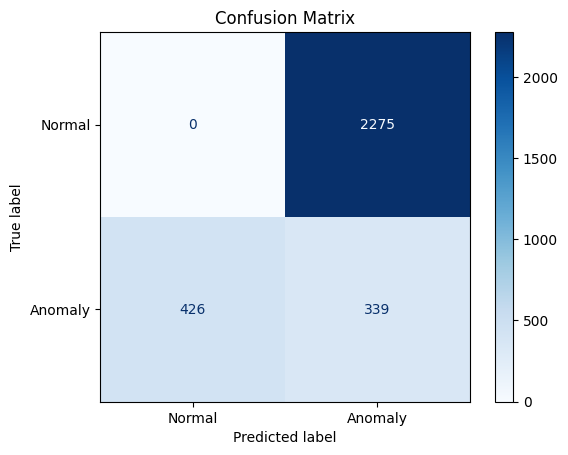

In [27]:
conf_matrix = confusion_matrix(y_true_all, y_pred_all)
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=['Normal', 'Anomaly'])
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()